In [48]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import eli5
from   eli5.sklearn import PermutationImportance
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error as MSE
import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')


In [40]:
df_base = pd.read_csv("../playground-series-s3e5./WineQT.csv")
df_train = pd.read_csv("../playground-series-s3e5./train.csv")
df_test = pd.read_csv("../playground-series-s3e5./test.csv")

df_base['train_test'] = 1 # Let base data be inclucded in training data, be = 1
df_train['train_test'] = 1 # Let training data be = 1
df_test['train_test'] = 0 # Let test data be = 0

df_whole = pd.concat([df_train, df_test, df_base])

In [42]:
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")
print(f"Base data shape: {df_base.shape}")
print(f"Whole data shape: {df_whole.shape}")

Training data shape: (2056, 14)
Test data shape: (1372, 13)
Base data shape: (1143, 14)
Whole data shape: (4571, 14)


In [3]:
df_train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,train_test
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6,1
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6,1
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7,1
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5,1
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6,1


In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    2056 non-null   int64  
 1   fixed acidity         2056 non-null   float64
 2   volatile acidity      2056 non-null   float64
 3   citric acid           2056 non-null   float64
 4   residual sugar        2056 non-null   float64
 5   chlorides             2056 non-null   float64
 6   free sulfur dioxide   2056 non-null   float64
 7   total sulfur dioxide  2056 non-null   float64
 8   density               2056 non-null   float64
 9   pH                    2056 non-null   float64
 10  sulphates             2056 non-null   float64
 11  alcohol               2056 non-null   float64
 12  quality               2056 non-null   int64  
 13  train_test            2056 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 225.0 KB


In [50]:
display(df_train.describe())

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,train_test
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.0
mean,1027.500000,8.365175,0.527601,0.265058,2.398881,0.081856,16.955982,49.236868,0.996748,3.310569,0.641308,10.414972,5.720817,1.0
std,593.660397,1.705390,0.173164,0.188267,0.858824,0.023729,10.009710,32.961141,0.001827,0.142321,0.137942,1.028825,0.853146,0.0
min,0.000000,5.000000,0.180000,0.000000,1.200000,0.012000,1.000000,7.000000,0.990070,2.740000,0.390000,8.700000,3.000000,1.0
25%,513.750000,7.200000,0.390000,0.090000,1.900000,0.071000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000,1.0
50%,1027.500000,7.950000,0.520000,0.250000,2.200000,0.079000,16.000000,44.000000,0.996700,3.310000,0.610000,10.100000,6.000000,1.0
75%,1541.250000,9.200000,0.640000,0.420000,2.600000,0.090000,24.000000,65.000000,0.997800,3.390000,0.720000,11.000000,6.000000,1.0
max,2055.000000,15.900000,1.580000,0.760000,14.000000,0.414000,68.000000,289.000000,1.003690,3.780000,1.950000,14.000000,8.000000,1.0


In [53]:
# Feature selection
feat_cols = ['fixed acidity', 'volatile acidity', 'citric acid',
             'residual sugar', 'chlorides', 'free sulfur dioxide',
             'total sulfur dioxide', 'density', 'pH', 'sulphates', 
             'alcohol']

target = 'quality'

Index(['Id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality', 'train_test'],
      dtype='object')


In [72]:
# Are there any duplicates in the dataset?
# and if any, how many missing data are there in each feature?
print(f'Number of duplicated records in training dataset (excl Id and quality): {df_whole.duplicated(subset = feat_cols).sum()}')
print(f'Number of NaN records in entire dataset (excl Id and quality): \n{df_whole[feat_cols].isna().sum()}')

# New shape?
df_whole = df_whole.drop_duplicates(subset = df_whole.columns.difference(['Id']))
print(f"New whole data shape: {df_whole.shape}")

Number of duplicated records in training dataset (excl Id and quality): 0
Number of NaN records in entire dataset (excl Id and quality): 
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64
New whole data shape: (4446, 14)


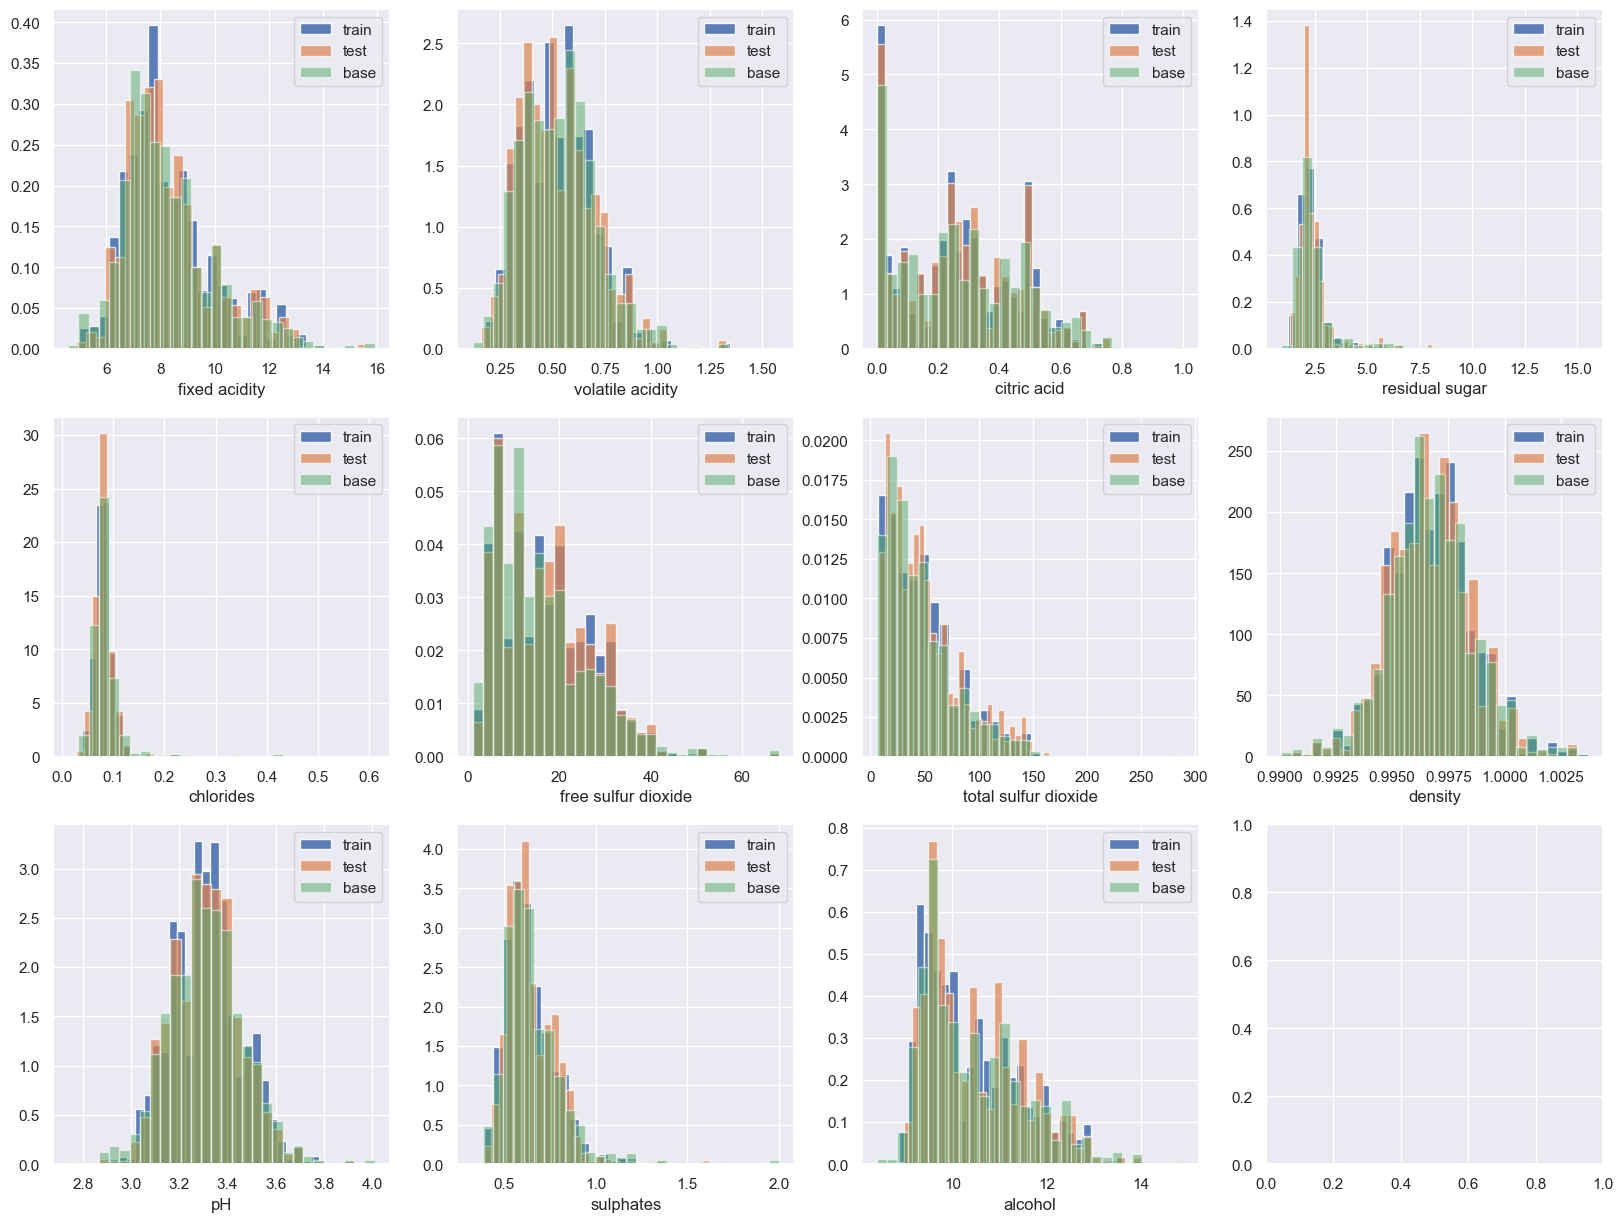

In [74]:
# Histograms
ncols = 4
nrows = math.ceil(len(feat_cols) / ncols)

plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

for idx, col in enumerate(feat_cols):

    plt.subplot(nrows, ncols, idx+1)
    plt.hist(df_train[col], bins=30, density=True, alpha=0.9, label='train')
    plt.hist(df_test[col], bins=30, density=True, alpha=0.7, label='test')
    plt.hist(df_base[col], bins=30, density=True, alpha=0.5, label='base')
    plt.xlabel(col)
    plt.legend()

plt.show()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.318436,0.695937,0.216517,0.173142,-0.238656,-0.129428,0.615600,-0.673701,0.142432,-0.025393,0.073852
volatile acidity,-0.318436,1.000000,-0.585697,-0.080067,0.034741,0.052753,0.083324,-0.075160,0.244171,-0.344014,-0.216296,-0.219287
citric acid,0.695937,-0.585697,1.000000,0.145187,0.141347,-0.191566,-0.085734,0.376759,-0.558444,0.260027,0.082065,0.141797
residual sugar,0.216517,-0.080067,0.145187,1.000000,0.086790,-0.098746,-0.022819,0.283797,-0.107332,0.031908,0.077594,0.048156
chlorides,0.173142,0.034741,0.141347,0.086790,1.000000,-0.049006,0.008749,0.250453,-0.128262,0.047200,-0.149921,-0.046624
free sulfur dioxide,-0.238656,0.052753,-0.191566,-0.098746,-0.049006,1.000000,0.637849,-0.067456,0.139392,-0.048248,-0.114734,-0.060217
total sulfur dioxide,-0.129428,0.083324,-0.085734,-0.022819,0.008749,0.637849,1.000000,0.112278,-0.016654,-0.151012,-0.319857,-0.225670
density,0.615600,-0.075160,0.376759,0.283797,0.250453,-0.067456,0.112278,1.000000,-0.388449,-0.002249,-0.355750,-0.153198
pH,-0.673701,0.244171,-0.558444,-0.107332,-0.128262,0.139392,-0.016654,-0.388449,1.000000,-0.045728,0.125008,0.016378
sulphates,0.142432,-0.344014,0.260027,0.031908,0.047200,-0.048248,-0.151012,-0.002249,-0.045728,1.000000,0.247288,0.366939


<AxesSubplot: >

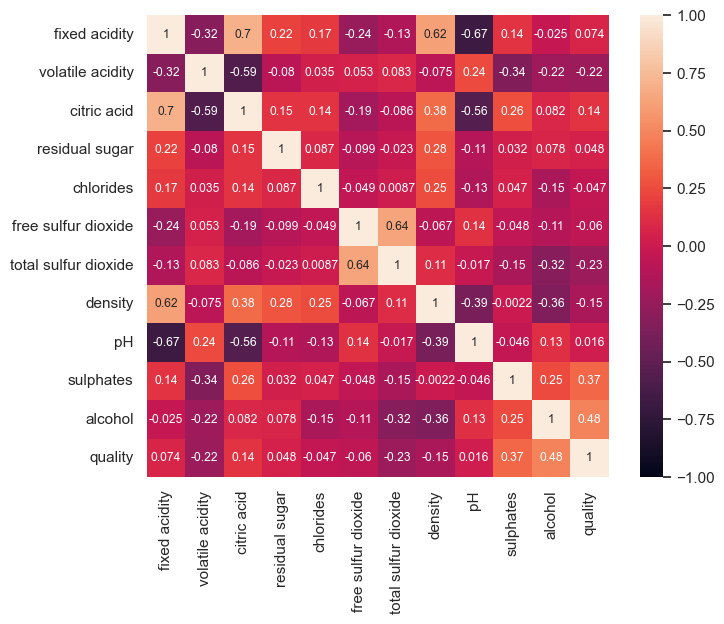

In [92]:
# Correlation
use_cols = feat_cols + [target]

display(pd.DataFrame(df_train[use_cols].corr()))
fig, ax = plt.subplots(figsize=(8, 6))
    
sns.heatmap(data = df_train[use_cols].corr(),
            square = True,
            vmin = -1, 
            vmax = 1, 
            annot = True,
            yticklabels = use_cols, 
            xticklabels = use_cols,
            annot_kws = {"size": 30 / np.sqrt(len(df_train[use_cols].corr()))},
)

In [ ]:
## util functions

# Set Whole Seed
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Cross Validation
def get_stratifiedkfold(train, target_col, n_splits, seed):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(kf.split(train, train[target_col])):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

# Save Results
def save_results(save_cfg, output_path: str):
    try:
        results_df = pd.read_csv(output_path)
    except:
        results_df = pd.DataFrame()
    results_df = results_df.append(asdict(save_cfg), ignore_index=True)
    results_df.to_csv(output_path, index=False)
    
# custom metric for lgbm classifier
def qwk_lgbm_classifier(y_true, preds):
    num_labels = 6
    y_pred = preds.reshape(num_labels, int(len(preds) // num_labels)).argmax(axis=0)
    return 'qwk', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

# Visualize Results
def multiclass_metrics(y_true: np.ndarray,
                       predict_probability: np.ndarray,
                       average: str = 'micro') -> dict:
    
    predict_label = np.argmax(predict_probability, axis=1)
    
    functions = [
        f1_score,
        precision_score,
        recall_score
    ]

    scores = {}
    # qwk
    scores['qwk'] = cohen_kappa_score(y_true, predict_label, weights='quadratic')
    # log loss
    scores['log_loss'] = log_loss(y_true, predict_probability)
    # accuracy
    scores['accuracy_score'] = accuracy_score(y_true, predict_label)
    for f in functions:
        score = f(y_true, predict_label, average=average)
        scores[f.__name__ + f'({average})'] = score

    return scores

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

def visualize_results(df_X: pd.DataFrame, y, 
                      models: list,
                      oof,
                      pred_prob,
                      output_dir: str,
                      model_name: str):
    # Multiclass Metrics
    display(pd.Series(multiclass_metrics(y, oof), name="oof"))
    # Feature importance
    if model_name == 'lgbm':
        fig, ax = visualize_importance(models, df_X)
        plt_path = os.path.join(output_dir, f'Feature_importance.png')
        plt.savefig(plt_path)
    plt.show()


**Simple Modelling**

In [9]:
# Splitting
X, y = df_train[features], df_train['quality']
  
# Splitting
train_X, val_X, train_y, val_y = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 1)
  
# Instantiation
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 50, seed = 123)
  
# Fitting the model
xgb_r.fit(train_X, train_y)
  
# Predict the model
pred = xgb_r.predict(val_X)

# RMSE Computation
rmse = np.sqrt(MSE(val_y, pred))
print(f"RMSE: {rmse}")
# Make prediction using entire test dataset
ypred = xgb_r.predict(X=df_test[features])
# We will look at the predicted prices to ensure we have something sensible.
print(ypred)
print((np.rint(ypred)).astype(int))

# Decision Tree Regressor submission
submission = pd.DataFrame({'Id': df_test.Id, 'quality': (np.rint(ypred)).astype(int)})
submission.to_csv('xgb_simp_submission.csv', index=False)

RMSE: 0.7046063218488844
[5.302214  6.2342067 5.4300513 ... 5.262645  5.1997037 5.4279156]
[5 6 5 ... 5 5 5]


**Scaling Features**

In [10]:
# # Logarithms Normalisation
# ['fixed acidity', 'volatile acidity', 'citric acid',
#        'residual sugar', 'chlorides', 'free sulfur dioxide',
#        'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# # df['norm_fixed_acidity'] = np.log(df['fixed acidity']+1)
# # df['norm_volatile_acidity'] = np.log(df['volatile acidity']+1)
# # df['norm_citric_acid'] = np.log(df['citric acid']+1)
# # df['norm_residual sugar'] = np.log(df['residual sugar']+1)
# # df['norm_fixed_acidity'] = np.log(df['fixed acidity']+1)
# # df['norm_fixed_acidity'] = np.log(df['fixed acidity']+1)
# # df['norm_fixed_acidity'] = np.log(df['fixed acidity']+1)
# # Z-Score / StandardScaler Normalisation
# from sklearn.preprocessing import StandardScaler

# # Create a StandardScaler object
# scaler = StandardScaler()

# # Fit the scaler to the column and transform the data
# df_norm = df
# for feature in features:
#        df_norm[feature] = scaler.fit_transform(df_norm[[feature]])


In [11]:
# df_train_norm = df_norm[df_norm.train_test == 1].drop(['train_test'], axis =1)
# df_test_norm = df_norm[df_norm.train_test == 0].drop(['train_test'], axis =1)

# # Splitting
# X, y = df_train_norm[features], df_train_norm['quality']
  
# # Splitting
# train_X, val_X, train_y, val_y = train_test_split(X, y,
#                                                   test_size = 0.2,
#                                                   random_state = 1)
  
# # Instantiation
# xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
#                   n_estimators = 50, seed = 123)
  
# # Fitting the model
# xgb_r.fit(train_X, train_y)
  
# # Predict the model
# pred = xgb_r.predict(val_X)

# # RMSE Computation
# rmse = np.sqrt(MSE(val_y, pred))
# print(f"RMSE: {rmse}")
# # Make prediction using entire test dataset
# ypred = xgb_r.predict(X=df_test[features])
# # We will look at the predicted prices to ensure we have something sensible.
# print(ypred)
# print((np.rint(ypred)).astype(int))

# # Decision Tree Regressor submission
# submission = pd.DataFrame({'Id': df_test.Id, 'quality': (np.rint(ypred)).astype(int)})
# submission.to_csv('xgb_norm_submission.csv', index=False)

**Tuning Model with Optuna**

In [12]:
def objective(trial, data = df_train[features], target=df_train['quality']):
    
    train_X, test_X, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 1)
    
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }

    model = xgb.XGBRegressor(**param)  
    model.fit(train_X,train_y,eval_set=[(test_X,test_y)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(test_X)
    rmse = MSE(test_y, preds,squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
Best_trial = study.best_trial.params
Best_trial["n_estimators"] = 10000

# Prediction iterates using Best_trial
preds = np.zeros(df_test.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]  # list contains rmse for each fold
n=0
for train_idx, test_idx in kf.split(df_train[features],df_train['quality']):
    train_X,val_X=df_train[features].iloc[train_idx],df_train[features].iloc[test_idx]
    y_tr,y_val=df_train['quality'].iloc[train_idx],df_train['quality'].iloc[test_idx]
    model = xgb.XGBRegressor(**Best_trial)
    model.fit(train_X,y_tr,eval_set=[(val_X,y_val)],early_stopping_rounds=100,verbose=False)
    preds+=model.predict(df_test[features])/kf.n_splits
    rmse.append(MSE(y_val, model.predict(val_X), squared=False))
    print(f"fold: {n+1} ==> rmse: {rmse[n]}")
    n+=1

print(np.mean(rmse))

submission = pd.DataFrame({'Id': df_test.Id, 'quality': (np.rint(preds)).astype(int)})
submission.to_csv('xgb_optuna_submission.csv', index=False)

[I 2023-02-02 12:15:37,000] A new study created in memory with name: no-name-861d2997-7ea4-45d5-8d8b-a5a8112c8467
[I 2023-02-02 12:15:38,304] Trial 0 finished with value: 0.6727902757518595 and parameters: {'lambda': 0.0010901070025493196, 'alpha': 3.724090964854814, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 128}. Best is trial 0 with value: 0.6727902757518595.
[I 2023-02-02 12:15:40,688] Trial 1 finished with value: 0.6707985792446296 and parameters: {'lambda': 0.08251075002502574, 'alpha': 0.0010131848646392034, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 175}. Best is trial 1 with value: 0.6707985792446296.
[I 2023-02-02 12:15:42,272] Trial 2 finished with value: 0.6689996896610045 and parameters: {'lambda': 4.908222770366416, 'alpha': 0.03262965421907814, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.012

Number of finished trials: 30
Best trial: {'lambda': 1.5937548215963218, 'alpha': 0.047437939059484235, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 38}
fold: 1 ==> rmse: 0.631289209879719
fold: 2 ==> rmse: 0.6776198368911247
fold: 3 ==> rmse: 0.6396168458933053
fold: 4 ==> rmse: 0.6790427810685095
fold: 5 ==> rmse: 0.7090392617901033
0.6673215871045522
